In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

In [5]:
df = pd.read_csv("HR_comma_sep.csv")

In [6]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [7]:
df.rename(columns={'sales':'Department'}, inplace=True)

In [8]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [10]:
print("Missing values:\n ", df.isnull().sum())

Missing values:
  satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
dtype: int64


In [16]:
df.shape


(14999, 10)

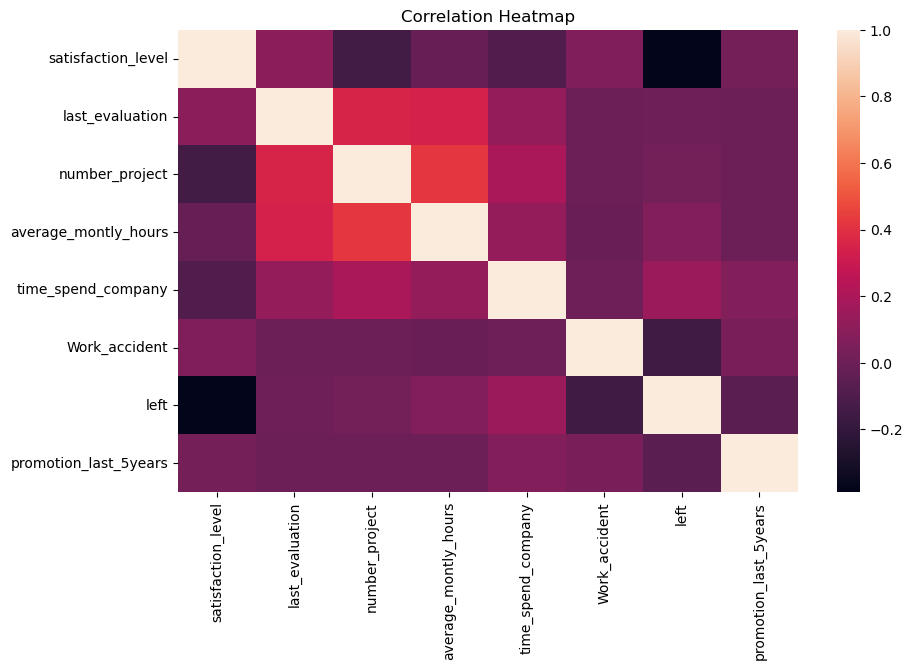

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.heatmap(df.select_dtypes(include=['number', 'float']).corr())
plt.title('Correlation Heatmap')
plt.show()

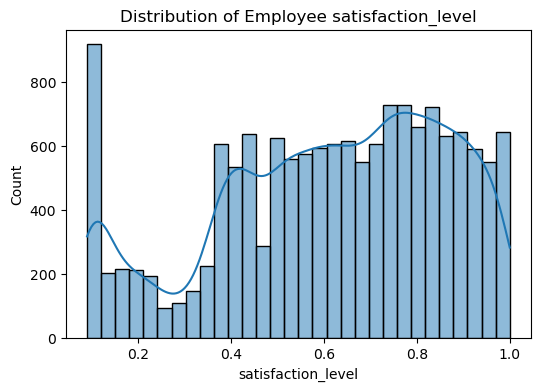

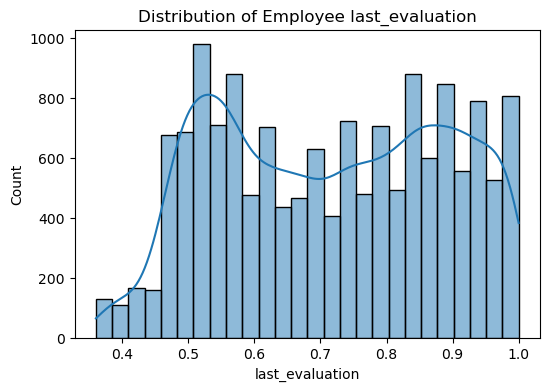

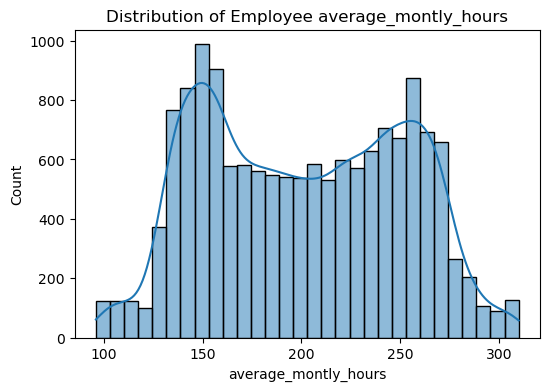

In [20]:
for col in ['satisfaction_level', 'last_evaluation', 'average_montly_hours']:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of Employee {col}")
    plt.show()

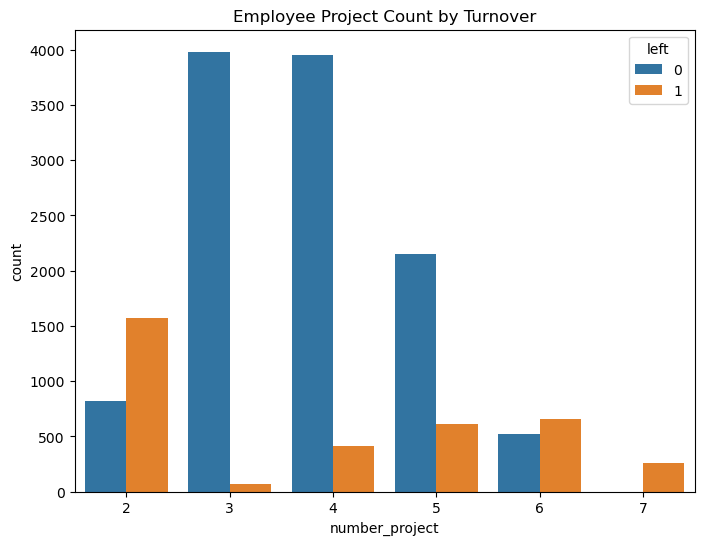

In [112]:
plt.figure(figsize=(8,6))
sns.countplot(x='number_project', hue='left', data=df)
plt.title("Employee Project Count by Turnover")
plt.show()

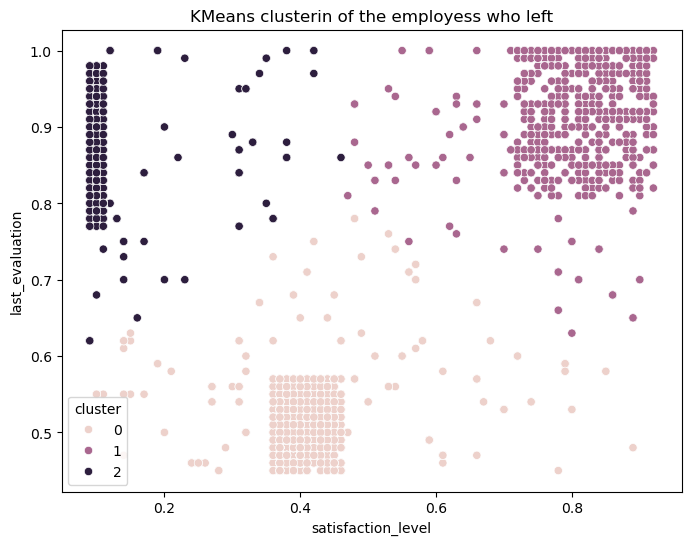

In [113]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
if 'left' in df.columns:
    left_df= df[df['left']== 1][['satisfaction_level', 'last_evaluation']].copy()
    scaler= StandardScaler()
    left_scaled=scaler.fit_transform(left_df)
    
    kmeans = KMeans(n_clusters= 3, random_state = 42)
    left_df['cluster']= kmeans.fit_predict(left_scaled)
    
    plt.figure(figsize= (8,6))
    sns.scatterplot(data=left_df, x= 'satisfaction_level', y= 'last_evaluation', hue= 'cluster')
    plt.title('KMeans clusterin of the employess who left')
    plt.show()
else:
    print('Column left not found in dataframe.')


In [31]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

df_encoded = pd.get_dummies(df, columns=['Department', 'salary'], drop_first=True)

In [33]:
# Train-test split
X = df_encoded.drop('left', axis=1)
y = df_encoded['left']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=123)

In [35]:
# SMOTE
smote = SMOTE(random_state=123)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

log_model = LogisticRegression(max_iter=1000)
rf_model = RandomForestClassifier()
gb_model = GradientBoostingClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

log_scores = cross_val_score(log_model, X_train_res, y_train_res, cv=cv, scoring='accuracy')
rf_scores = cross_val_score(rf_model, X_train_res, y_train_res, cv=cv, scoring='accuracy')
gb_scores = cross_val_score(gb_model, X_train_res, y_train_res, cv=cv, scoring='accuracy')

print("\nLogistic Regression - 5-Fold CV Accuracy:", log_scores)
print("Average Accuracy:", np.mean(log_scores))
print("\nRandom Forest - 5-Fold CV Accuracy:", rf_scores)
print("Average Accuracy:", np.mean(rf_scores))
print("\nGradient Boosting - 5-Fold CV Accuracy:", gb_scores)
print("Average Accuracy:", np.mean(gb_scores))


Logistic Regression - 5-Fold CV Accuracy: [0.79874214 0.79245283 0.7973749  0.79983593 0.78884026]
Average Accuracy: 0.7954492119367013

Random Forest - 5-Fold CV Accuracy: [0.98906207 0.98386656 0.98331966 0.98632759 0.98413567]
Average Accuracy: 0.9853423098532893

Gradient Boosting - 5-Fold CV Accuracy: [0.96089691 0.96445174 0.96335794 0.96062346 0.96444201]
Average Accuracy: 0.9627544130168515


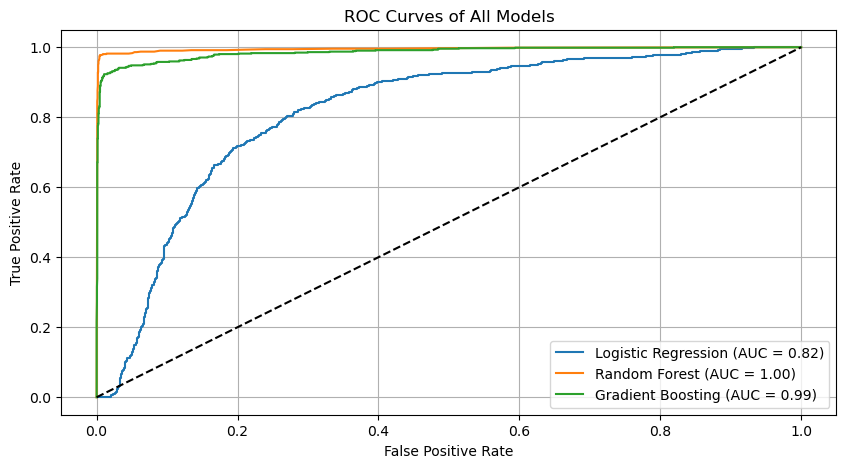

In [79]:
# 6.1: ROC Curve and AUC for Each Model
log_model.fit(X_train_res, y_train_res)
rf_model.fit(X_train_res, y_train_res)
gb_model.fit(X_train_res, y_train_res)

log_probs = log_model.predict_proba(X_test)[:, 1]
rf_probs = rf_model.predict_proba(X_test)[:, 1]
gb_probs = gb_model.predict_proba(X_test)[:, 1]

fpr_log, tpr_log, _ = roc_curve(y_test, log_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_probs)

auc_log = roc_auc_score(y_test, log_probs)
auc_rf = roc_auc_score(y_test, rf_probs)
auc_gb = roc_auc_score(y_test, gb_probs)

plt.figure(figsize=(10, 5))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {auc_log:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})")
plt.plot(fpr_gb, tpr_gb, label=f"Gradient Boosting (AUC = {auc_gb:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves of All Models")
plt.legend()
plt.grid(True)
plt.show()


Logistic Regression Confusion Matrix:


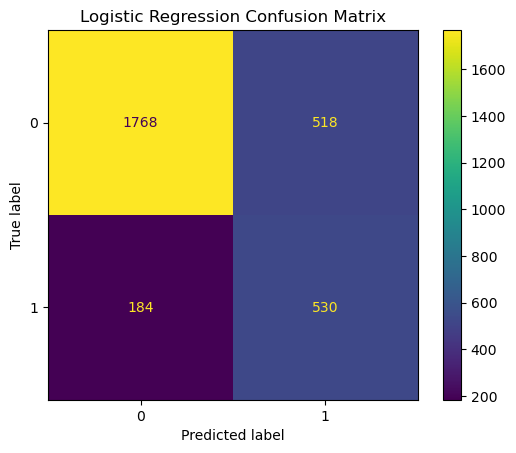


Random Forest Confusion Matrix:


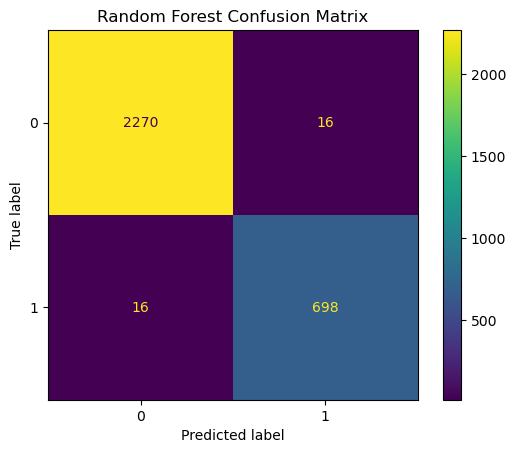


Gradient Boosting Confusion Matrix:


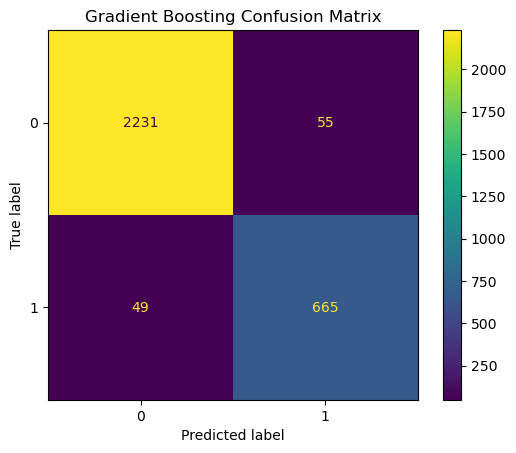

In [71]:
# 6.2: Confusion Matrices for Each Model
log_pred = log_model.predict(X_test)
rf_pred = rf_model.predict(X_test)
gb_pred = gb_model.predict(X_test)

print("\nLogistic Regression Confusion Matrix:")
ConfusionMatrixDisplay(confusion_matrix(y_test, log_pred)).plot()
plt.title("Logistic Regression Confusion Matrix")
plt.show()

print("\nRandom Forest Confusion Matrix:")
ConfusionMatrixDisplay(confusion_matrix(y_test, rf_pred)).plot()
plt.title("Random Forest Confusion Matrix")
plt.show()

print("\nGradient Boosting Confusion Matrix:")
ConfusionMatrixDisplay(confusion_matrix(y_test, gb_pred)).plot()
plt.title("Gradient Boosting Confusion Matrix")
plt.show()


In [75]:
# 6.3: Precision vs Recall
print("\nInterpretation:")
print("In employee turnover prediction, RECALL is often more important than PRECISION.")
print("Why? Because we want to catch as many true leavers as possible (minimize false negatives).")
print("Even if we flag some false positives, it's better than missing people likely to leave.")


Interpretation:
In employee turnover prediction, RECALL is often more important than PRECISION.
Why? Because we want to catch as many true leavers as possible (minimize false negatives).
Even if we flag some false positives, it's better than missing people likely to leave.


In [81]:
# Risk Zone Categorization and Retention Strategies
best_model = GradientBoostingClassifier()
best_model.fit(X_train_res, y_train_res)
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:,1]

risk_scores = pd.DataFrame({'probability': y_prob})
risk_scores['risk_zone'] = pd.cut(risk_scores['probability'],
                                  bins=[0.0, 0.2, 0.6, 0.9, 1.0],
                                  labels=['Safe', 'Low-Risk', 'Medium-Risk', 'High-Risk'])
print(risk_scores['risk_zone'].value_counts())


risk_zone
Safe           2094
High-Risk       619
Low-Risk        208
Medium-Risk      79
Name: count, dtype: int64
